In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
results_dir = '../results'

In [3]:
from utils import read_files, spider_eval

data = read_files(
    results_dir=results_dir,
    models=['Meta-Llama-3.1-8B-Instruct'],
    methods=['smc'],
    runs=[1],
    n_particles_list=[1, 5, 10],
    ess_thresholds=[0.5, 0.7, 0.9],
    proposals=['character'],
)

/home/lebrunb/genparse/bench/ben_experiments/analysis/utils.py:95: UserWarning: ../results/Meta-Llama-3.1-8B-Instruct/character/smc/Meta-Llama-3.1-8B-Instruct-smc-1-0.7-p1-character.jsonl : could not find file
  warnings.warn(f'{fp} : could not find file')
/home/lebrunb/genparse/bench/ben_experiments/analysis/utils.py:95: UserWarning: ../results/Meta-Llama-3.1-8B-Instruct/character/smc/Meta-Llama-3.1-8B-Instruct-smc-1-0.9-p1-character.jsonl : could not find file
  warnings.warn(f'{fp} : could not find file')


In [10]:
from evaluate import run_and_add_evaluation

data = run_and_add_evaluation(data, n_workers=10, overwrite=True)

  0%|          | 0/7238 [00:00<?, ?it/s]

 34%|███▍      | 2476/7238 [00:22<00:31, 152.33it/s]

Function cached_eval timed out after 10 seconds


 35%|███▌      | 2538/7238 [00:40<00:30, 152.33it/s]

Function cached_eval timed out after 10 seconds
Function cached_eval timed out after 10 seconds
Function cached_eval timed out after 10 seconds


 78%|███████▊  | 5634/7238 [41:28<11:48,  2.26it/s] 


In [ ]:
import json
import os

p = os.path.join(
    results_dir, 'Llama-3.1-8B-Instruct-smc-0.5,0.7,0.9-1,5,10-character.jsonl'
)
with open(p, 'w') as f:
    for l in data:
        print(json.dumps(l), file=f)

In [52]:
local_poe_data = read_files(
    results_dir=results_dir,
    models=['Meta-Llama-3.1-8B-Instruct'],
    methods=['local'],
    runs=[1],
    n_particles_list=[1, 5, 10],
    ess_thresholds=[0.5],  # ignored
    proposals=['character'],
)

In [ ]:
local_poe_data = run_and_add_evaluation(local_poe_data, run_mbr=False, overwrite=True)

In [53]:
from utils import make_experiment_df

experiment_df = make_experiment_df(data + local_poe_data)

experiment_df.tail(5)

/home/lebrunb/genparse/bench/ben_experiments/analysis/utils.py:143: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/home/lebrunb/genparse/bench/ben_experiments/analysis/utils.py:143: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/home/lebrunb/genparse/bench/ben_experiments/analysis/utils.py:143: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. 

,model,method,ess_threshold,run,n_particles,proposal,log_ml,example_id,num_resample_steps,level,mbr,posterior_weighted_acc,viterbi,posterior_weighted_acc_exec,mbr_exec,viterbi_exec
0,Meta-Llama-3.1-8B-Instruct,local,NaN,1,10,character,0.0,What are the citizenships that are shared by s...,NaN,hard,False,0.3,NaN,NaN,NaN,NaN
0,Meta-Llama-3.1-8B-Instruct,local,NaN,1,10,character,0.0,How many available features are there in total...,NaN,easy,True,0.9,NaN,NaN,NaN,NaN
0,Meta-Llama-3.1-8B-Instruct,local,NaN,1,10,character,0.0,What is the feature type name of feature AirCo...,NaN,medium,True,0.8,NaN,NaN,NaN,NaN
0,Meta-Llama-3.1-8B-Instruct,local,NaN,1,10,character,0.0,Show the property type descriptions of propert...,NaN,medium,False,0.1,NaN,NaN,NaN,NaN
0,Meta-Llama-3.1-8B-Instruct,local,NaN,1,10,character,0.0,What are the names of properties that are eith...,NaN,hard,False,0.0,NaN,NaN,NaN,NaN


In [ ]:
from util import melt_and_add_confidence_intervals

In [109]:
import pandas as pd
from utils import binomial_ci, mean_cl

accs = (
    experiment_df.groupby(['model', 'n_particles', 'method', 'ess_threshold'])
    .apply(
        lambda x: pd.Series(
            {
                **binomial_ci(x, 'mbr'),
                **binomial_ci(x, 'viterbi'),
                **mean_cl(x, 'posterior_weighted_acc'),
            }
        )
    )
    .reset_index()
)

accs

/var/tmp/ipykernel_2319842/5234665.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,model,n_particles,method,mbr_mean,mbr_lwr,mbr_upr,viterbi_mean,viterbi_lwr,viterbi_upr,posterior_weighted_acc_mean,posterior_weighted_acc_lwr,posterior_weighted_acc_upr
0,Meta-Llama-3.1-8B-Instruct,1,smc,0.558994,0.529014,0.588975,0.558994,0.529014,0.588975,0.558994,0.528731,0.589258
1,Meta-Llama-3.1-8B-Instruct,5,smc,0.697292,0.669246,0.725338,0.626692,0.596712,0.655706,0.599697,0.575026,0.624367
2,Meta-Llama-3.1-8B-Instruct,10,local,0.722437,0.695358,0.749516,NaN,NaN,NaN,0.561896,0.538857,0.584934
3,Meta-Llama-3.1-8B-Instruct,10,smc,0.719961,0.692829,0.747093,0.636628,0.607558,0.665698,0.605631,0.581913,0.629349


/home/lebrunb/miniconda3/envs/genparse/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


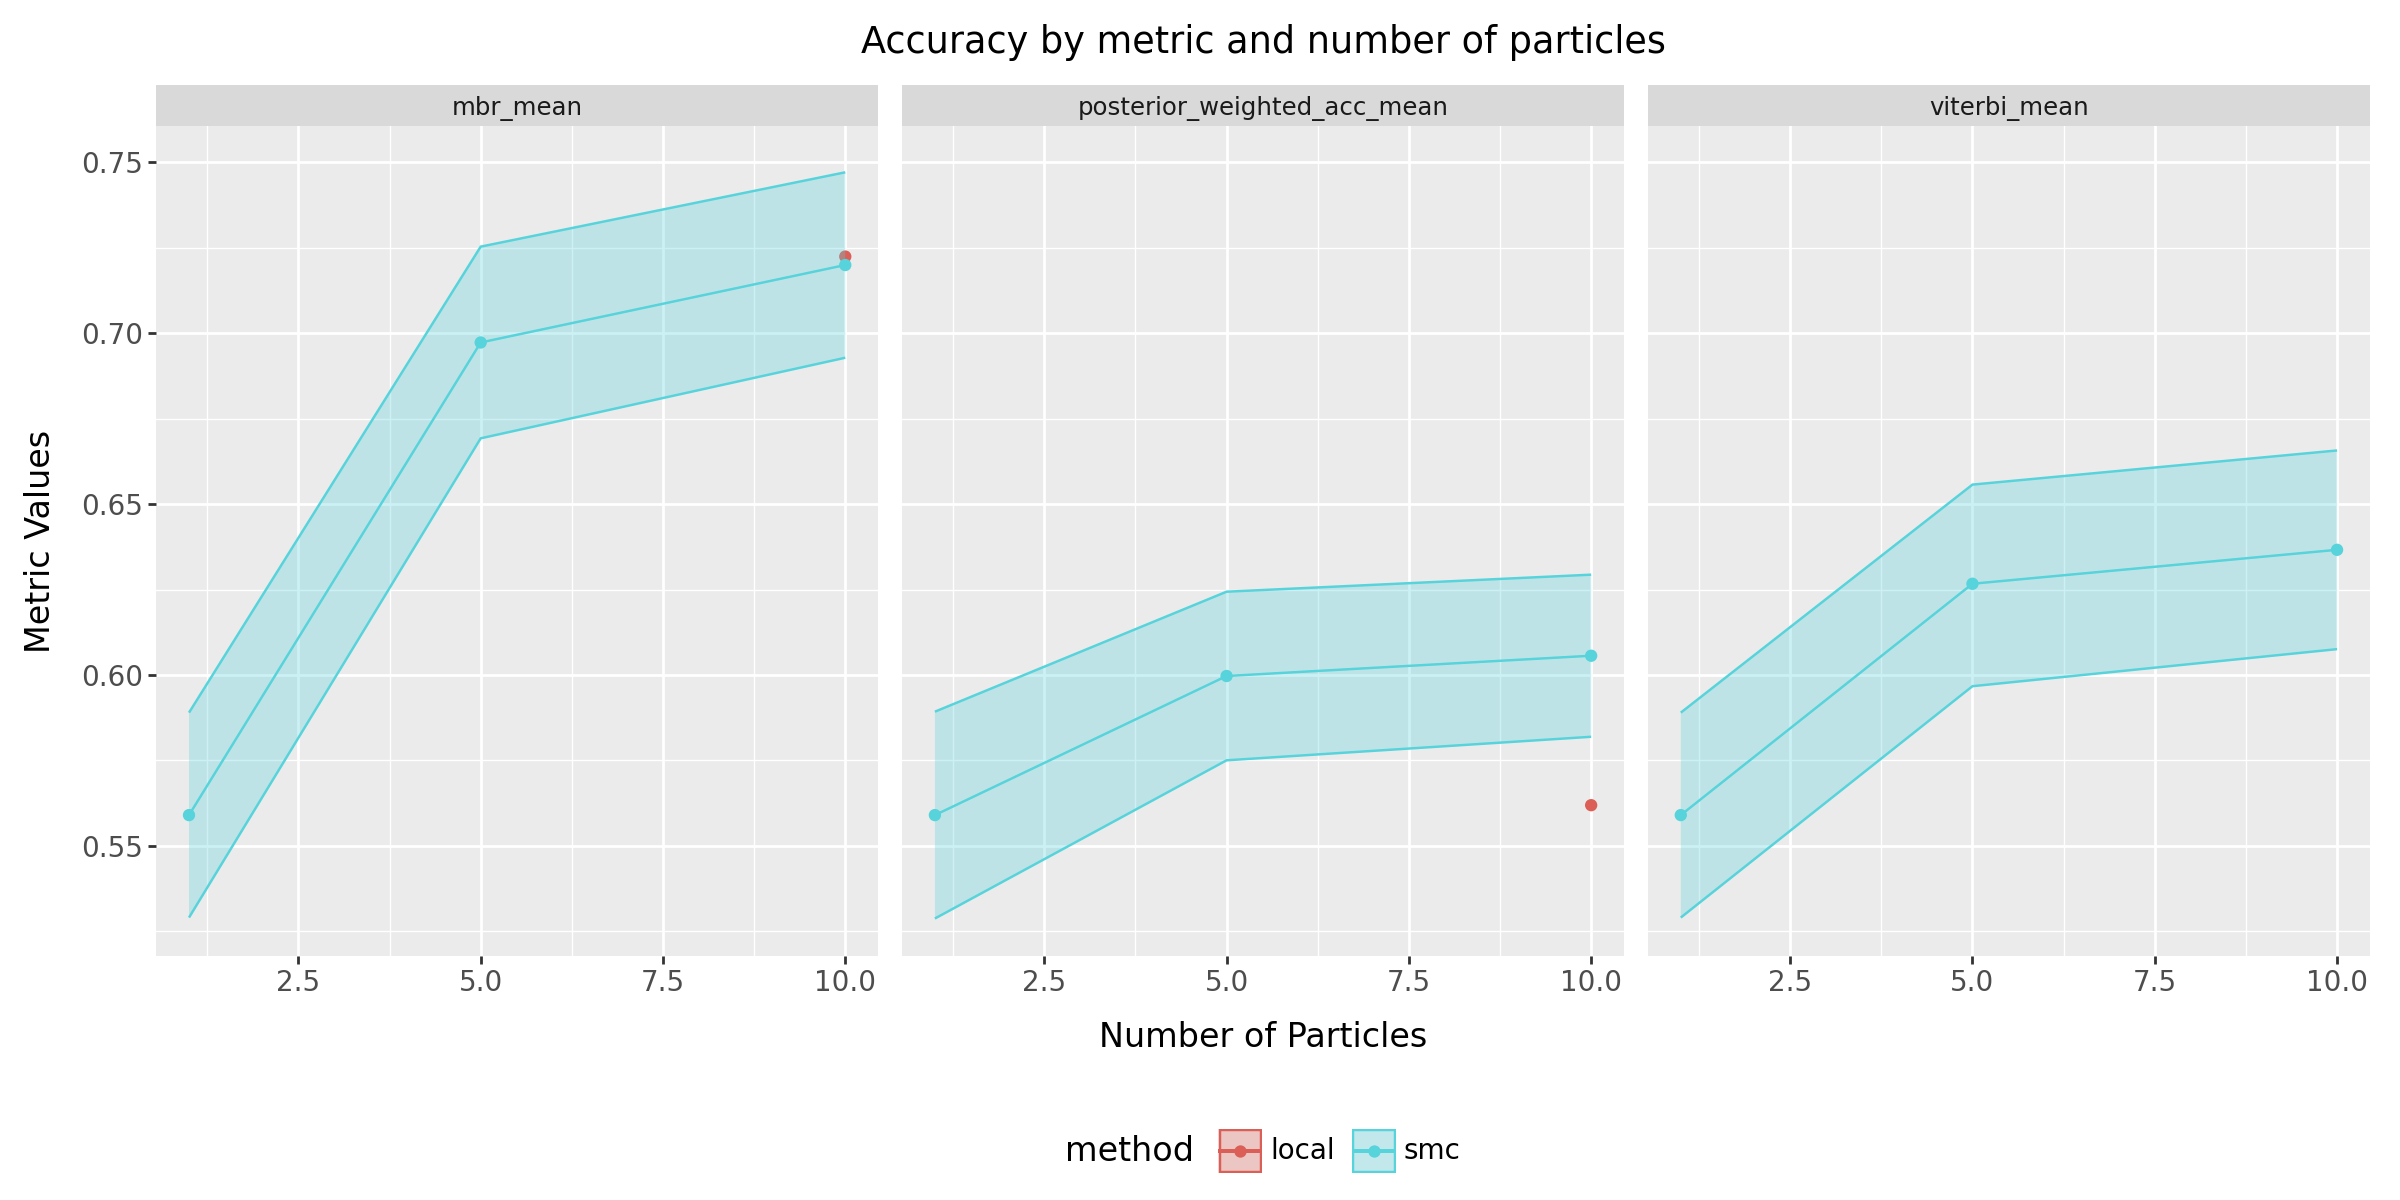

In [110]:
from plotnine import (
    ggplot,
    aes,
    geom_line,
    geom_point,
    geom_errorbar,
    facet_wrap,
    theme,
    labs,
    geom_ribbon,
    element_text,
)

df = accs

df_melted = melt_and_add_confidence_intervals(
    df,
    id_vars=['n_particles', 'model', 'method'],
    value_vars=['mbr_mean', 'viterbi_mean', 'posterior_weighted_acc_mean'],
)

p = (
    ggplot(df_melted, aes(x='n_particles', y='mean', color='method', fill='method'))
    + geom_line()
    + geom_point()
    + geom_ribbon(aes(ymin='lwr', ymax='upr'), alpha=0.3)
    + facet_wrap('~metric', scales='free_x')
    + theme(
        figure_size=(12, 6),
        legend_position='bottom',
        legend_title=element_text(size=12),
        legend_text=element_text(size=10),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10),
    )
    + labs(
        title='Accuracy by metric and number of particles',
        x='Number of Particles',
        y='Metric Values',
        fill='method',
        color='method',
    )
)

p.show()

In [9]:
from genparse import EOS

EOS

'▪'

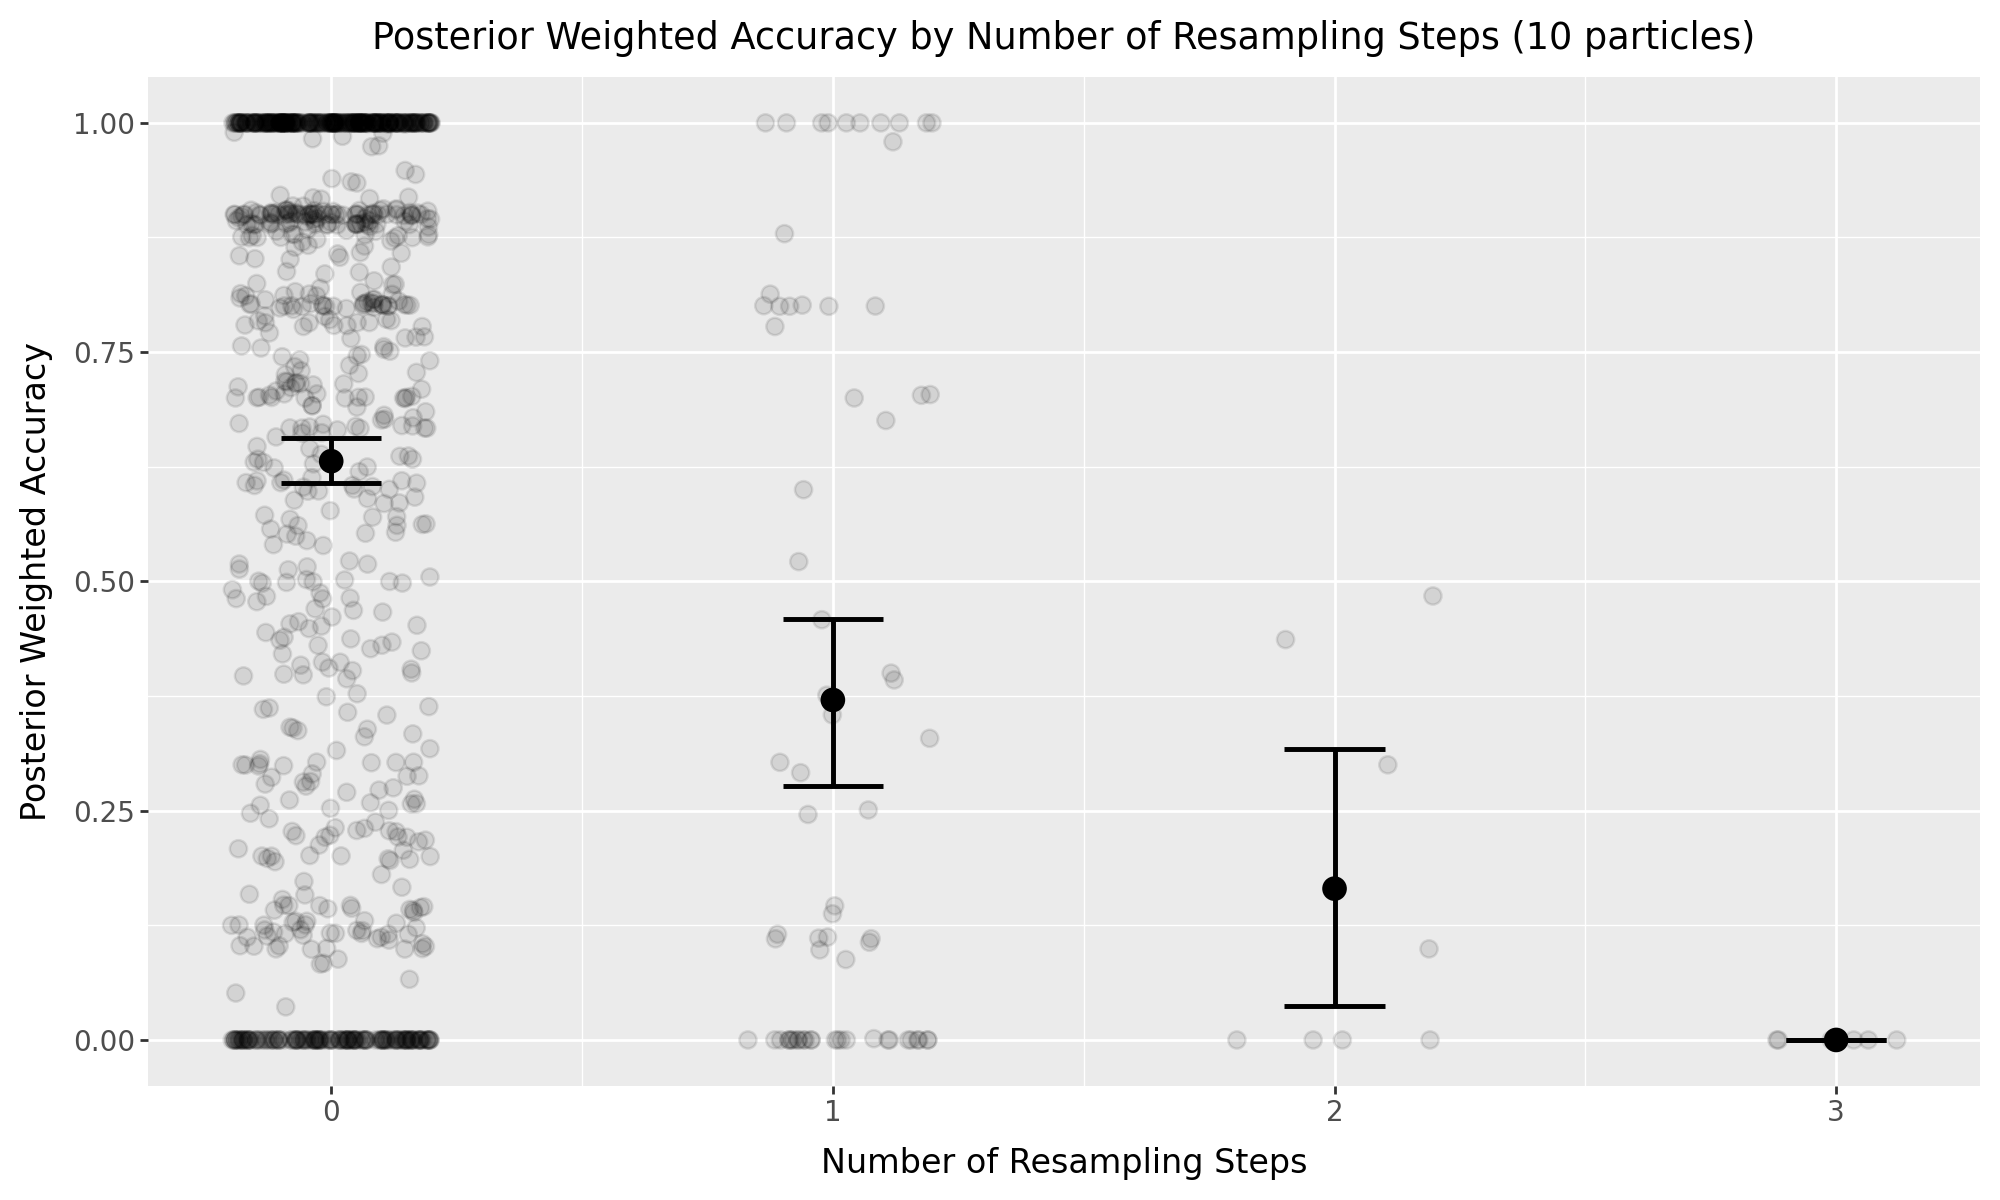

In [8]:
from plotnine import geom_jitter, stat_summary, geom_histogram

p = (
    ggplot(
        experiment_df[experiment_df['n_particles'] == 10],
        aes(x='num_resample_steps', y='posterior_weighted_acc'),
    )
    + geom_jitter(width=0.2, height=0, alpha=0.1, size=3)  # Add jittered points
    + stat_summary(fun_data='mean_cl_boot', geom='point', size=4, color='black')
    + stat_summary(fun_data='mean_cl_boot', geom='errorbar', width=0.2, size=1)
    + theme(
        figure_size=(10, 6),
        legend_position='bottom',
        legend_title=element_text(size=12),
        legend_text=element_text(size=10),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10),
    )
    + labs(
        title='Posterior Weighted Accuracy by Number of Resampling Steps (10 particles)',
        x='Number of Resampling Steps',
        y='Posterior Weighted Accuracy',
    )
)

p.show()

experiment_data[experiment]

In [97]:
resampled_ids = experiment_df[
    (experiment_df['num_resample_steps'] > 0)
    & (experiment_df['method'] == 'smc')
    & (experiment_df['n_particles'] == 10)
]['example_id']
resampled_instances = experiment_df[experiment_df['example_id'].isin(resampled_ids)]
resampled_instances = resampled_instances[resampled_instances['n_particles'] == 10]

assert len(resampled_ids) * 2 == len(resampled_instances)

resampled_accs = (
    resampled_instances.groupby(['method'])
    .apply(
        lambda x: pd.Series(
            {
                **binomial_ci(x, 'mbr'),
                **binomial_ci(x, 'viterbi'),
                **mean_cl(x, 'posterior_weighted_acc'),
            }
        )
    )
    .reset_index()
)

resampled_accs['instances'] = 'resampled'

/var/tmp/ipykernel_2319842/3778042871.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [98]:
all_instances = experiment_df[experiment_df['n_particles'] == 10]

accs = (
    all_instances.groupby(['method'])
    .apply(
        lambda x: pd.Series(
            {
                **binomial_ci(x, 'mbr'),
                **binomial_ci(x, 'viterbi'),
                **mean_cl(x, 'posterior_weighted_acc'),
            }
        )
    )
    .reset_index()
)

accs['instances'] = 'all'

/var/tmp/ipykernel_2319842/1809371768.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [100]:
pd.concat([accs, resampled_accs])

,method,mbr_mean,mbr_lwr,mbr_upr,viterbi_mean,viterbi_lwr,viterbi_upr,posterior_weighted_acc_mean,posterior_weighted_acc_lwr,posterior_weighted_acc_upr,instances
0,local,0.722437,0.695358,0.749516,NaN,NaN,NaN,0.561896,0.538857,0.584934,all
1,smc,0.719961,0.692829,0.747093,0.636628,0.607558,0.665698,0.605631,0.581913,0.629349,all
0,local,0.430233,0.325581,0.534884,NaN,NaN,NaN,0.209302,0.153048,0.265557,resampled
1,smc,0.465116,0.360465,0.569767,0.302326,0.209302,0.406977,0.325733,0.246323,0.405142,resampled


In [94]:
df_melted

,method,instances,metric,mean,lwr,upr
0,local,all,mbr_mean,0.722437,0.695358,0.749516
1,smc,all,mbr_mean,0.719961,0.692829,0.747093
2,local,resampled,mbr_mean,0.430233,0.695358,0.749516
3,smc,resampled,mbr_mean,0.465116,0.692829,0.747093
4,local,all,posterior_weighted_acc_mean,0.561896,0.538857,0.584934
5,smc,all,posterior_weighted_acc_mean,0.605631,0.581913,0.629349
6,local,resampled,posterior_weighted_acc_mean,0.209302,0.538857,0.584934
7,smc,resampled,posterior_weighted_acc_mean,0.325733,0.581913,0.629349


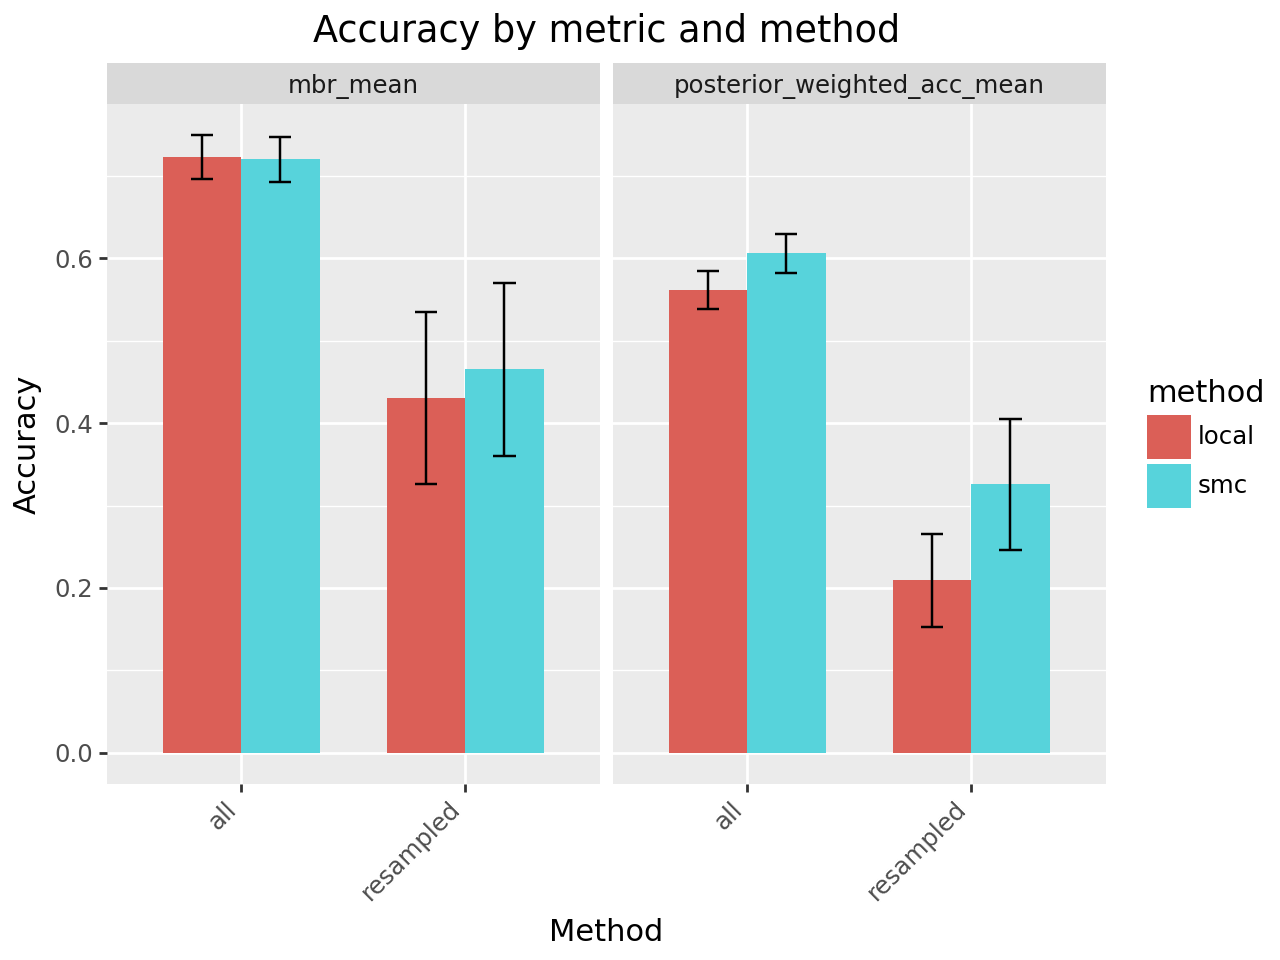

In [107]:
from plotnine import geom_bar, position_dodge

df = pd.concat([accs, resampled_accs])


def melt_and_add_confidence_intervals(df, id_vars, value_vars):
    df_melted = df.melt(
        id_vars=id_vars, value_vars=value_vars, var_name='metric', value_name='mean'
    )

    def get_confidence_interval(row, conf_type):
        condition = pd.Series(True, index=df.index)
        for var in id_vars:
            condition &= df[var] == row[var]
        return df.loc[condition, row['metric'].replace('_mean', conf_type)].values[0]

    df_melted['lwr'] = df_melted.apply(
        lambda x: get_confidence_interval(x, '_lwr'), axis=1
    )
    df_melted['upr'] = df_melted.apply(
        lambda x: get_confidence_interval(x, '_upr'), axis=1
    )

    return df_melted


dodge = position_dodge(width=0.7)

df_melted = melt_and_add_confidence_intervals(
    df,
    id_vars=['method', 'instances'],
    value_vars=['mbr_mean', 'posterior_weighted_acc_mean'],
)

p = (
    ggplot(df_melted, aes(x='instances', y='mean', fill='method'))
    + geom_bar(stat='identity', position=dodge, width=0.7)
    + geom_errorbar(aes(ymin='lwr', ymax='upr'), position=dodge, width=0.2)
    + facet_wrap('~ metric')
    + labs(x='Method', y='Accuracy', title='Accuracy by metric and method')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

p.show()

In [78]:
df_melted

,method,metric,mean,lwr,upr
0,local,mbr_mean,0.430233,0.325581,0.534884
1,smc,mbr_mean,0.465116,0.360465,0.569767
2,local,posterior_weighted_acc_mean,0.209302,0.153048,0.265557
3,smc,posterior_weighted_acc_mean,0.325733,0.246323,0.405142


In [68]:
resampled_instances

,model,method,ess_threshold,run,n_particles,proposal,log_ml,example_id,num_resample_steps,level,mbr,posterior_weighted_acc,viterbi,posterior_weighted_acc_exec,mbr_exec,viterbi_exec
0,Meta-Llama-3.1-8B-Instruct,smc,0.5,1,10,character,-1.341843,"For each stadium, how many concerts play there...",1.0,medium,False,0.000000,0.0,0.000000,False,False
0,Meta-Llama-3.1-8B-Instruct,smc,0.5,1,10,character,-2.114895,Show the stadium name and capacity with most n...,2.0,extra,True,0.484111,0.0,0.836654,True,True
0,Meta-Llama-3.1-8B-Instruct,smc,0.5,1,10,character,-2.686788,What is the name and capacity of the stadium w...,1.0,extra,True,0.137587,0.0,0.352660,True,True
0,Meta-Llama-3.1-8B-Instruct,smc,0.5,1,10,character,-0.904429,Find the name and location of the stadiums whi...,1.0,extra,True,0.458210,0.0,0.803057,True,True
0,Meta-Llama-3.1-8B-Instruct,smc,0.5,1,10,character,-1.172303,Find the number of dog pets that are raised by...,1.0,hard,True,0.800255,1.0,0.800255,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Meta-Llama-3.1-8B-Instruct,local,NaN,1,10,character,0.000000,Compute the average age of all the dogs.-dog_k...,NaN,easy,True,0.200000,NaN,NaN,NaN,NaN
0,Meta-Llama-3.1-8B-Instruct,local,NaN,1,10,character,0.000000,Tell me the age of the oldest dog.-dog_kennels,NaN,easy,True,0.700000,NaN,NaN,NaN,NaN
0,Meta-Llama-3.1-8B-Instruct,local,NaN,1,10,character,0.000000,What are the song titles and singer names?-singer,NaN,medium,True,0.800000,NaN,NaN,NaN,NaN
0,Meta-Llama-3.1-8B-Instruct,local,NaN,1,10,character,0.000000,Show distinct names of singers that have songs...,NaN,medium,True,0.700000,NaN,NaN,NaN,NaN


In [ ]:
# look at avg score for lpoe vs smc

# Case analysis

In [32]:
mismatches = []
invalids = []

for datum in data:
    particles = datum['results']['posterior_weighted_acc']['particle_results']
    for p, res in particles.items():
        if not res[0]:
            if res[1] == 'mismatch':
                mismatches.append([p, datum['gold']])
            else:
                invalids.append([p, datum['gold']])

In [33]:
len(mismatches)

3194

In [35]:
invalids[10]

['SELECT count(*) FROM   singer_in_concert WHERE Concert_ID IN (SELECT concert_id FROM concert WHERE year IN (SELECT year FROM concert GROUP BY YEAR ORDER BY capacity DESC LIMIT 1));',
 'select count(*) from concert where stadium_id = (select stadium_id from stadium order by capacity desc limit 1)']

In [ ]:
[
    'SELECT count(*) FROM   singer_in_concert WHERE Concert_ID IN (SELECT concert_id FROM concert WHERE year IN (SELECT year FROM concert GROUP BY YEAR ORDER BY capacity DESC LIMIT 1));',
    'select count(*) from concert where stadium_id = (select stadium_id from stadium order by capacity desc limit 1)',
]

In [60]:
data[2500]['results']['posterior_weighted_acc'], data[2500]['db_name']

({'result': 0.9020810125138944,
  'particle_results': {"SELECT first_name, birth_date FROM players WHERE country_code = 'USA';": [True,
    None],
   "SELECT T1.first_name, T1.birth_date FROM players AS T1 WHERE T1.country_code = 'USA';": [True,
    None],
   "SELECT first_name, birth_date FROM players WHERE country_code = 'usa';": [False,
    'mismatch']}},
 'wta_1')

# Non-incremental execution potential

In [9]:
import bench.spider.evaluation as E
from pathlib import Path

spider_dir = Path('../../spider/data/spider')

In [19]:
import numpy as np
from pathlib import Path
from bench.spider.evaluator import Evaluator

evaluator = Evaluator(spider_dir)
eos = '▪'

spider_dir = Path('../../spider/data/spider')


def evaluation_potential(pred, db_name):
    db = spider_dir / 'database' / db_name / (db_name + '.sqlite')
    schema = E.Schema(E.get_schema(db))

    pred = pred.rstrip('▪')

    try:
        E.get_sql(schema, pred)
    except Exception:
        return -np.inf

    return 0


from genparse.experimental.batch_inference.steer import ParticleApproximation, Particle

from functools import lru_cache


@lru_cache
def cached_eval(x, y, db):
    return evaluator.evaluate(x, y, db_name=db)


def reweight_particles_approx(particles, db):
    return ParticleApproximation(
        [
            Particle(
                prompt=None,
                context=p['context'],
                context_ids=p['context_ids'],
                done=True,
                log_weight=p['weight'] + evaluation_potential(''.join(p['context']), db),
                log_weight_updates=None,
                parent=None,
            )
            for p in particles
        ]
    )


def mbr_eval(particles, gold, db):
    def match(x, y):
        x = x.rstrip(eos)
        y = y.rstrip(eos)
        try:
            (exec_match, _) = cached_eval(x, y, db_name=db)
        except Exception:
            exec_match = False
        return exec_match

    pmax = max(
        particles,
        key=lambda candidate: particles.risk(match, ''.join(candidate.context)),
    )

    pred = ''.join(pmax.context[:-1])

    return {
        'result': cached_eval(gold, pred, db),
        'pred': pred,
        'finished': pmax.done,
        'tokens': pmax.context,
        'token_ids': pmax.context_ids,
    }


def viterbi_eval(particles, gold, db):
    pmax = particles.particles[0]
    for p in particles.particles[1:]:
        if p.done and p.log_weight > pmax.log_weight:
            pmax = p

    pred = ''.join(pmax.context).rstrip(eos)

    return {
        'result': cached_eval(gold, pred, db),
        'pred': pred,
        'finished': pmax.done,
        'tokens': pmax.context,
        'token_ids': pmax.context_ids,
    }


def posterior_weighted_eval(particles, gold, db):
    weighted_acc = 0
    particle_results = {}
    for pred, p in particles.posterior.items():
        if np.isnan(p):
            p = 0
        pred = pred.rstrip(eos)
        acc = cached_eval(gold, pred, db)
        assert pred not in particle_results, pred
        particle_results[pred] = acc
        weighted_acc += p * acc[0]

    return {'result': weighted_acc, 'particle_results': particle_results}


def eval_with_execution_potential(particles, gold, db):
    approx = reweight_particles_approx(particles, db)
    return {
        'posterior_weighted_acc_exec': posterior_weighted_eval(approx, gold, db),
        'mbr_exec': mbr_eval(approx, gold, db),
        'viterbi_exec': viterbi_eval(approx, gold, db),
    }

In [27]:
from tqdm import tqdm

for datum in tqdm(data):
    db_name = datum['db_name']
    gold = datum['gold']
    particles = datum['record']['history'][-1]['particles']
    datum['results'].update(eval_with_execution_potential(particles, gold, db_name))

  0%|          | 0/3100 [00:00<?, ?it/s]

/home/lebrunb/miniconda3/envs/genparse/lib/python3.10/site-packages/arsenal/maths/util.py:447: RuntimeWarning: invalid value encountered in subtract
/home/lebrunb/genparse/genparse/experimental/batch_inference/steer.py:96: RuntimeWarning: divide by zero encountered in log
100%|██████████| 3100/3100 [44:31<00:00,  1.16it/s]    


In [29]:
experiment_df = make_experiment_df(data)

In [30]:
import pandas as pd

accs = (
    experiment_df.groupby(['model', 'n_particles', 'method'])
    .apply(
        lambda x: pd.Series(
            {
                **binomial_ci(x, 'mbr'),
                **binomial_ci(x, 'viterbi'),
                **mean_cl(x, 'posterior_weighted_acc'),
                **binomial_ci(x, 'mbr_exec'),
                **binomial_ci(x, 'viterbi_exec'),
                **mean_cl(x, 'posterior_weighted_acc_exec'),
            }
        )
    )
    .reset_index()
)

accs

/var/tmp/ipykernel_2319842/1466890598.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,model,n_particles,method,mbr_mean,mbr_lwr,mbr_upr,viterbi_mean,viterbi_lwr,viterbi_upr,posterior_weighted_acc_mean,...,posterior_weighted_acc_upr,mbr_exec_mean,mbr_exec_lwr,mbr_exec_upr,viterbi_exec_mean,viterbi_exec_lwr,viterbi_exec_upr,posterior_weighted_acc_exec_mean,posterior_weighted_acc_exec_lwr,posterior_weighted_acc_exec_upr
0,Meta-Llama-3.1-8B-Instruct,1,smc,0.558994,0.529014,0.588975,0.558994,0.529014,0.588975,0.558994,...,0.589258,0.558994,0.529014,0.588975,0.558994,0.529014,0.588975,0.558994,0.528731,0.589258
1,Meta-Llama-3.1-8B-Instruct,5,smc,0.697292,0.669246,0.725338,0.626692,0.596712,0.655706,0.599697,...,0.624367,0.697292,0.669246,0.725338,0.678917,0.649903,0.706963,0.660675,0.635542,0.685809
2,Meta-Llama-3.1-8B-Instruct,10,smc,0.719961,0.692829,0.747093,0.636628,0.607558,0.665698,0.605631,...,0.629349,0.719961,0.692829,0.747093,0.693798,0.665698,0.721899,0.672719,0.648963,0.696475


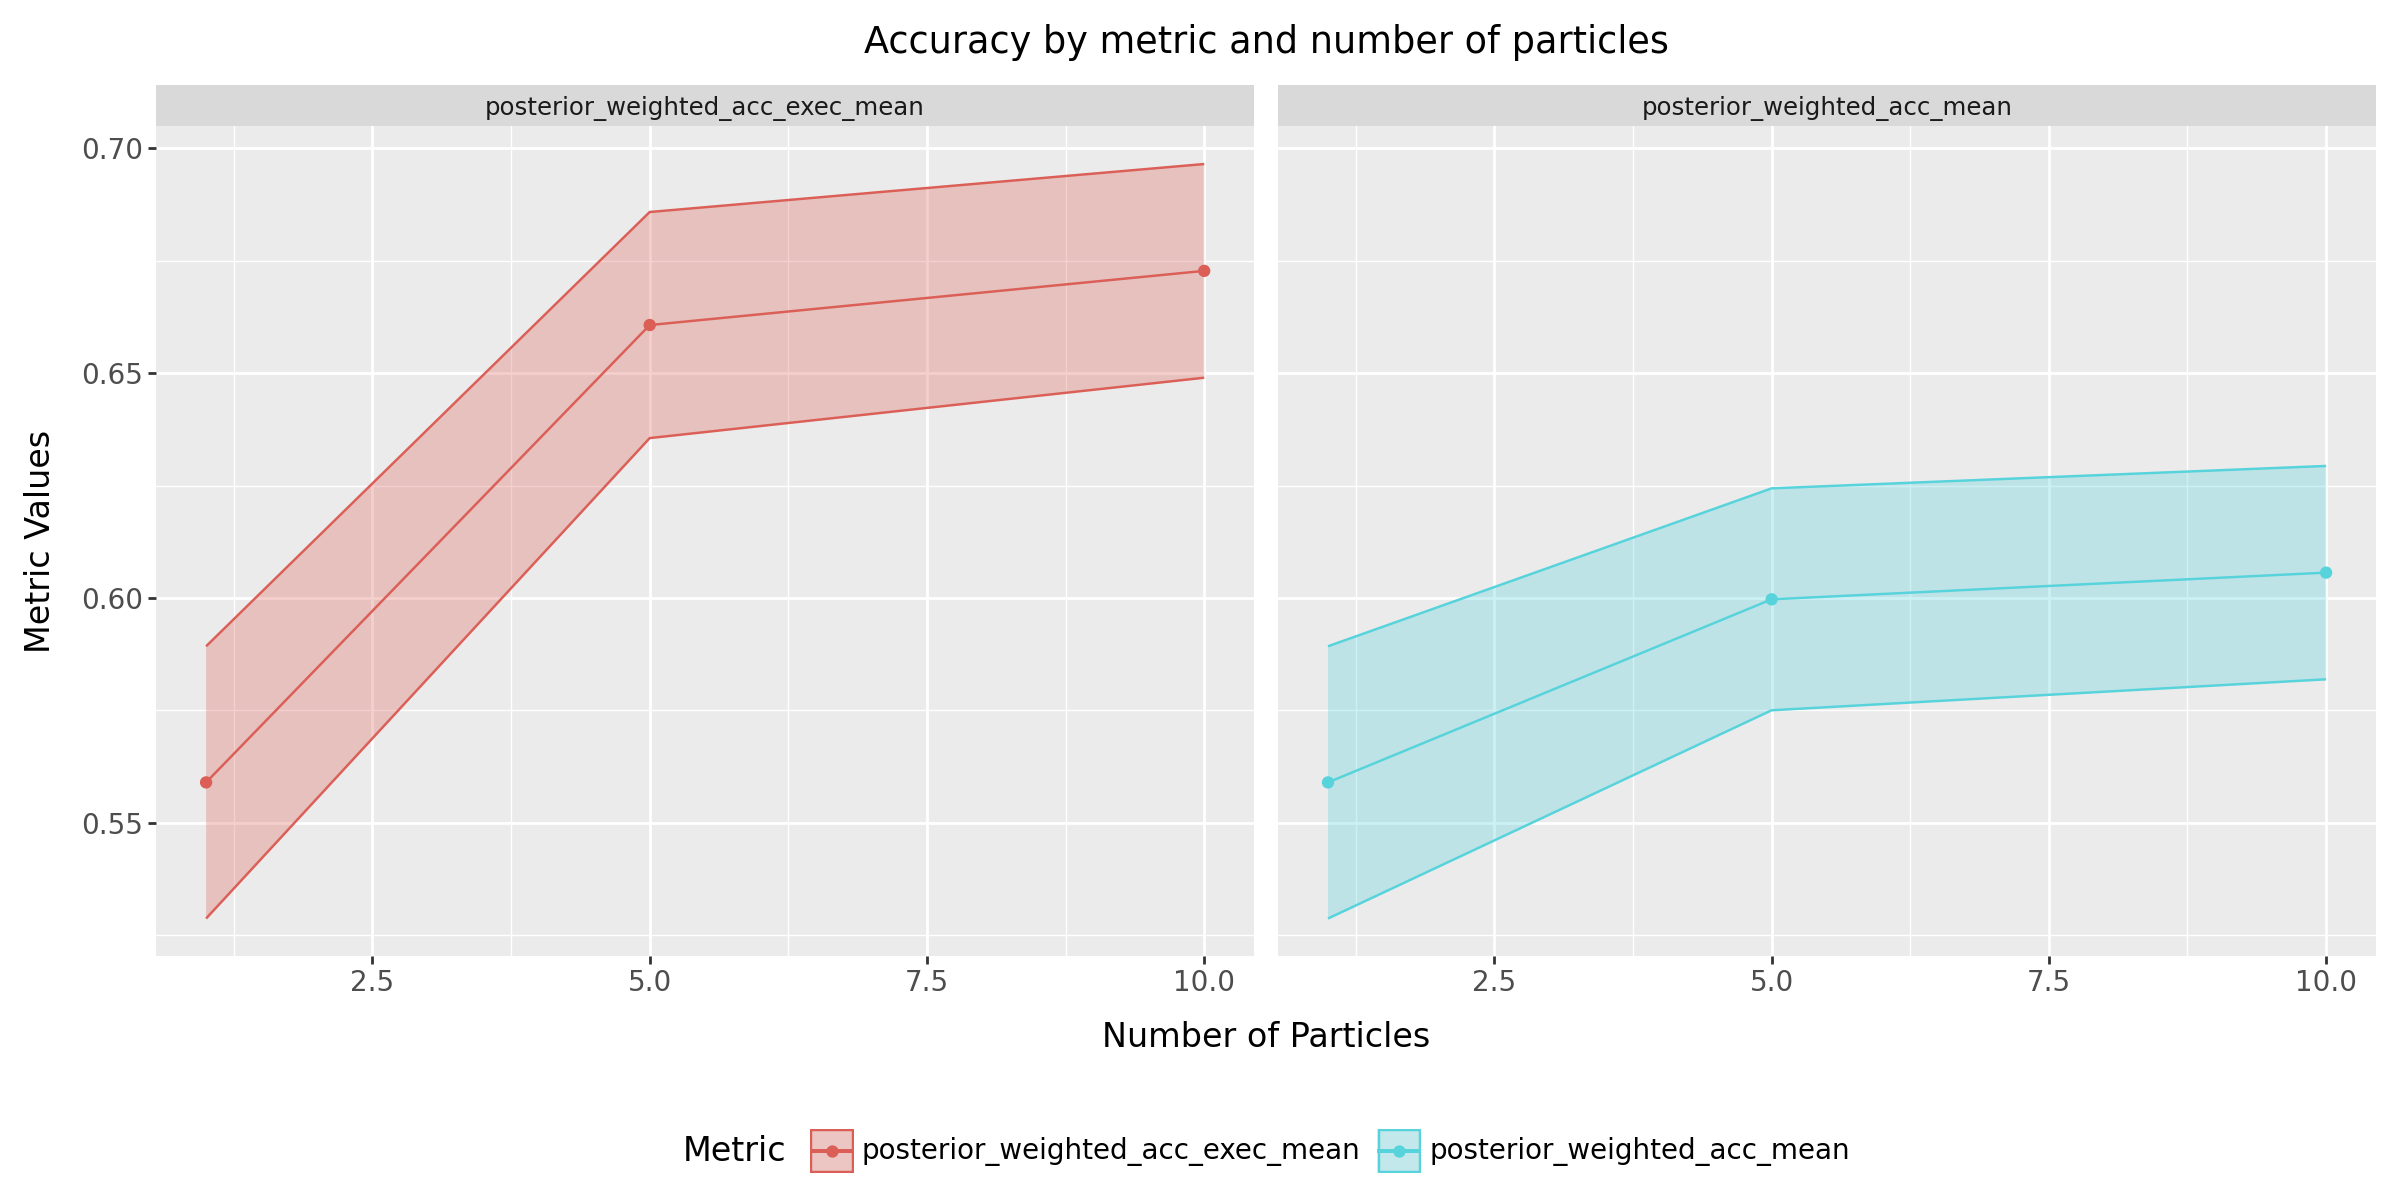

In [16]:
df = accs

df_melted = df.melt(
    id_vars=['n_particles', 'model', 'method'],
    value_vars=['posterior_weighted_acc_mean', 'posterior_weighted_acc_exec_mean'],
    var_name='metric',
    value_name='mean',
)

df_melted['lwr'] = df_melted.apply(
    lambda x: df.loc[
        (df['n_particles'] == x['n_particles'])
        & (df['model'] == x['model'])
        & (df['method'] == x['method']),
        x['metric'].replace('_mean', '_lwr'),
    ].values[0],
    axis=1,
)
df_melted['upr'] = df_melted.apply(
    lambda x: df.loc[
        (df['n_particles'] == x['n_particles'])
        & (df['model'] == x['model'])
        & (df['method'] == x['method']),
        x['metric'].replace('_mean', '_upr'),
    ].values[0],
    axis=1,
)

p = (
    ggplot(df_melted, aes(x='n_particles', y='mean', color='metric', fill='metric'))
    + geom_line()
    + geom_point()
    + geom_ribbon(aes(ymin='lwr', ymax='upr'), alpha=0.3)
    + facet_wrap('~metric', scales='free_x')
    + theme(
        figure_size=(12, 6),
        legend_position='bottom',
        legend_title=element_text(size=12),
        legend_text=element_text(size=10),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10),
    )
    + labs(
        title='Accuracy by metric and number of particles',
        x='Number of Particles',
        y='Metric Values',
        fill='Metric',
        color='Metric',
    )
)

p.show()